# 설정

In [1]:
# 파이썬 ≥ 3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥ 0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Perceptron"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

이 장에서는 분류를 위한 초창기 머신 러닝 알고리즘인 퍼셉트론을 사용한다. 간단한 역사와 논리 게이트를 통해 퍼셉트론의 한계, 그리고 이를 극복한 방법까지 알아보도록 한다. 또한, 파이썬으로 단계적으로 퍼셉트론을 구현하고 붓꽃 데이터셋에서 훈련하여 꽃 품종을 분류한다. 분류를 위한 머신 러닝 알고리즘 개념을 이해하고, 파이썬을 사용한 효율적인 구현 방법을 익히는 데 도움이 될 것이다.

# 인공 뉴런: 초기 머신 러닝의 간단한 역사

<b>퍼셉트론</b><sup>perceptron</sup>과 이와 관련된 알고리즘을 자세히 설명하기 전에 초창기 머신 러닝을 간단히 둘러보자. AI를 설계하기 위해 생물학적 뇌가 동작하는 방식을 이해하려는 시도로, 1943년 워런 맥컬록<sup>Warren McCulloch</sup>과 월터 피츠<sup>Walter Pitts</sup>는 처음으로 간소화된 뇌의 뉴런 개념을 발표했다.<sup id="a01">[1](#p01)</sup> 이를 <b>맥컬록-피츠</b><sup>MCP</sup> 뉴런이라고 하며 '최초의 인공 신공망'모델이다. 뉴런들은 뇌의 신경 세포와 서로 연결되어 있다. 이들은 다음 그림과 같이 화학적 · 전기적 신호를 처리하고 전달하는 데 관여한다.

<b>그림 1</b> 뇌의 신경 세포
<div style="text-align:center;">
    <img src="./images/Perceptron/뇌의 신경 세포.png">
</div>

뉴런은 <b>수상 돌기</b><sup>Dendrite</sup>를 통해 신호를 전달받으며 받은 신호는 <b>세포체</b><sup>Cell body</sup>로 보낸다. 이때 여러 수상 돌기를 통해 들어온 신호가 세포체에 모이고, 신호가 특정 임계 값을 넘으면 세포체는 펄스 또는 스파이크 단위로 신호를 발생시킨다. 세포체가 신호를 발생시키는 과정을 <b>발화</b><sup>frigger</sup>라고 하며 발화된 신호는 <b>축삭</b><sup>Axon</sup>을 통해 다음 뉴런에 전달된다. 뉴런이 전기 신호를 전달하는 활동 전위 상태에 있으면 뉴런이 <b>활성화</b><sup>activation</sup>된 것이다.

맥컬록과 피츠는 신경 세포를 이진 출력을 내는 간단한 논리 회로로 표현했다. 신경 생리학자인 맥컬록은 인간의 신경계를 범용 계산 장치로 모델링할 수 있을지 궁금해했고 천재 수학자 피츠를 만나면서 생체 뉴런의 특성을 지니는 최초의 인공 신경망을 정의했다.

이들이 정의한 인공 신경망 모델은 활성 상태와 비활성 상태를 갖는 <b>이진 뉴런</b><sup>binary neuron</sup>으로 구성되며 생체 뉴런과 같이 시냅스의 흥분과 억제에 따라 신호가 전달되고 특정 임계치를 넘어야 신호가 발화한다.

맥컬론과 피츠는 이진 뉴런으로 구성된 신경망이 튜링 머신과 동등한 연산을 수행할 수 있음을 증명했다. 생체 신경망을 수학적으로 모델링했을 때 임의의 논리 연산과 산술 연산이 가능하다는 것을 보여줌으로써 인간의 두뇌가 잠재적으로 매우 강력한 연산 장치임을 증명하고자 했던 것이다. 이진 뉴런으로 구성된 신경망 모델은 AI의 창시자이자 현대 컴퓨터의 구조를 제시한 <b>폰 노이만</b><sup>John von Neumann</sup>에게도 큰 영향을 끼쳤으며 이런 점에서 맥컬록-피츠 모델은 학문적으로 중요하며 그 가치를 높게 평가받고 있다.

## 시냅스 가소성과 기억의 흔적

우리 몸에 새로운 자극이 들어오면 신호를 전달하는 뉴런의 시냅스에는 소포체와 수용체가 많지 않은 상태이기 때문에 신경 전달 물질도 적게 전달된다. 하지만 같은 자극이 반복되면 소포체와 수용체의 수가 점점 늘어나서 신경 전달 물질을 원활히 전달하는 구조로 변화한다. 이처럼 신호를 전달하는 뉴런이 자주 활성화될 때 신호 전달을 강화하기 위해 시냅스 구조가 변하는 성질을 시냅스 <b>가소성</b><sup>plasticity</sup>이라고 한다. 신호 전달이 강화되면 '뉴런이 연결되었다'고 말하며 변화된 시냅스 구조를 '기억의 흔적'이라고 부른다.

시냅스 가소성은 1949년 캐나다의 신경 심리학자 도널드 헵<sup>Donald O. Hebb</sup>이 <b>헵의 학습 가설</b><sup>Hebbian learning</sup>로 발표했다. '지속해서 활성화되는 뉴런은 연결된다'라는 가설을 통해, 학습 과정에서 형성되는 장기 기억이 시냅스의 구조 변화와 연관되어 있음을 시사했다.

학계에서는 헵의 학습 가설을 바탕으로 시냅스 구조의 변화 과정을 '학습과 기억의 현상'으로 받아들이고 있다. 인간이 무언가 경험하거나 학습할 때는 신호가 발생하며, 이 신호가 신경망을 통해 전달되는 과정에서 기존 기억과 연합한다. 이때 새로운 신호가 연관된 기억을 만나면 연결이 추가되며 관련된 기억 간에 연결이 강화되기도 한다. 그에 따라 <b>신호와 관련된 뉴런의 가지는 굵어지고 연결은 많아지면서 장기 기억이 뇌에 자리 잡는 것</b>이다. 반대로 활성화되지 않은 뉴런은 연결이 약해진다. 이런 과정이 끊임없이 반복되면서 기억은 새롭게 만들어지거나 변화되고 확장되며 오래된 기억은 사라지다. 우리 뇌에는 1,000억 개의 뉴런이 있고 각 뉴런은 수천에서 수만 개의 시냅스 연결을 가진다. 기억을 새로 만들거나, 강화하거나 약화하기 위해 100조 개에 달하는 시냅스 연결이 끊임없이 변화한다. 인간의 뇌는 효율적인 구조로 기억을 관리하기 위해 시냅스의 연결 패턴과 강도를 매 순간 바꾸는 것이다.

## 학습하는 인공 신경망: 퍼셉트론

그러나 맥컬록-피츠 모델은 학습 과정이 없다 보니 문제에 따라 신경망의 구성도 매번 바꿔야 했다. 이런 단점을 해결하기 위해 프랑크 로젠블라트<sup>Frank Rosenblatt</sup>는 MCP 뉴런 모델과 헵의 학습 가설을 기반으로 인공 신경망이 스스로 문제에 맞춰 학습하는 모델인 퍼셉트론 학습 개념을 처음 발표했다.<sup id="a02">[2](#p02)</sup> 퍼셉트론 규칙에서 로젠블라트는 자동으로 최적의 가중치를 학습하는 알고리즘을 제안했다. 이 가중치는 뉴런의 출력 신호를 낼지 말지를 결정하기 위해 입력 특성에 곱하는 계수로, 각 입력 신호가 결과에 주는 영향력을 조절하는 요소로 작용한다. 즉, 퍼셉트론의 학습 알고리즘은 새로운 입력에 대한 오차가 발생하면 뉴런의 연결 강도(가중치)를 조절하는 방식이다. 지도 학습의 분류 개념으로 말하면 이 알고리즘으로 샘플이 한 클래스에 속하는지 아닌지를 예측할 수 있다.

## 인공 뉴런의 수학적 정의

좀 더 형식적으로 말하면 <b>인공 뉴런</b><sup>artificial neuron</sup> 아이디어를 두 개의 클래스가 있는 <b>이진 분류</b><sup>binary classification</sup> 작업으로 볼 수 있다. 두 클래스는 간단하게 1을 양성 클래스<sup>positive class</sup>, -1을 음성 클래스<sup>negative class</sup>로 나타낸다. 그다음 입력 값 <i><strong>x</strong></i>와 이에 상응하는 가중치 벡터 <strong>w</strong>의 선형 조합으로 결정 함수(<i>Φ(z)</i>)를 정의한다. 최종 입력<sup>net input</sup>인 <i>z</i>는 <i>z = w<sub>1</sub>x<sub>1</sub> + ... + w<sub>m</sub>x<sub>m</sub>이다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/w_x_feat.png">
</div>

이제 특정 샘플 <i><strong>x</strong><sup>(i)</sup></i> 의 최종 입력이 사전에 정의된 임계 값 <i>θ</i>보다 크면 클래스 1로 예측하고, 그렇지 않으면 클래스 -1로 예측한다. 퍼셉트론 알고리즘에서 결정 함수 <i>Φ(·)</i>는 <b>단위 계단 함수</b><sup>unit step function</sup><sup id="a03">[3](#p03)</sup>를 변형한 것이다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/per_act_fun.png">
</div>

식을 간단하게 만들기 위해 임계 값 <i>θ</i>를 식의 왼쪽으로 옮겨 <i>w<sub>0</sub> = -θ</i>, <i>x<sub>0</sub> = 1</i>인 0번째 가중치를 정의한다. 이렇게 하면 <i>z</i>를 좀 더 간단하게 쓸 수 있다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/z_feat.png">
</div>

그리고 결정 함수는 다음과 같다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/per_act_r_fun.png">
</div>

머신 러닝 분야에서는 음수 임계 값 또는 가중치 <i>w<sub>0</sub>=-θ</i>를 <b>절편</b>이라고 한다. 다음 그림은 퍼셉트론 결정 함수로 최종 입력 z = <strong>w<sup>T</sup>x</strong>가 이진 출력(-1 또는 1)으로 압축되는 방법(왼쪽)과 이를 사용하여 선형 분리가 가능한 두 개의 클래스를 직선으로 분류하는 <b>선형 분류기</b><sup>linear classifier</sup>(오른쪽)를 보여준다. 입력 데이터와 가중치의 가중 합산 식은 두 클래스를 분류하는 <b>결정 경계</b><sup>decision boundary</sup>를 이룬다.

<b>그림 2</b> 퍼셉트론의 결정 함수와 결정 경계
<div style="text-align:center;">
    <img src="./images/Perceptron/퍼셉트론의 결정 함수와 결정 경계.png">
</div>

즉, 퍼셉트론의 가중 합산이 0인 <i>z = w<sub>0</sub>x<sub>0</sub> + ... + w<sub>m</sub>x<sub>m</sub></i> = 0 식은 결정 경계<sup id="a04">[4](#p04)</sup>를 이루는 직선의 방정식으로 가중치 벡터 <b>w</b>는 직선의 법선 벡터<sup>normal vector</sup>를, 편향 w<sub>0</sub>x<sub>0</sub>는 원점과 직선 사이의 거리를 나타낸다. 만일 편향이 0이면 직선이 항상 원점을 지나므로 임의의 위치에 있는 두 종류의 클래스를 완벽히 분류할 수 없다. 직선을 경계로 법선 벡터 방향에 있는 점들은 계단 함수의 실행 결과가 1이 되어 클래스 1로 분류되고, 법선 벡터의 반대 방향에 있는 점들은 계단 함수의 실행 결과가 0이 되어 클래스 -1로 분류된다.

### 생체 신경망을 모방하여 만든 퍼셉트론

퍼셉트론은 생체 신경망을 모방해서 만들었다. 그렇다면 퍼셉트론은 어떤 점에서 생체 신경망을 닮았다고 하는 것일까? 다음 그림을 보면 퍼셉트론이 데이터를 처리하는 과정과 생체 뉴런의 신호 전달 과정이 어떻게 대응되는지를 확인해 볼 수 있다.

<b>그림 3</b> 생체 신경망과 퍼셉트론
<div style="text-align:center;">
    <img src="./images/Perceptron/생체 신경망을 모방하여 만든 퍼셉트론.png">
</div>

퍼셉트론이 데이터를 처리하는 과정과 생체 뉴런의 신호 전달 과정을 순서대로 대응해 보면 다음 표와 같이 정리할 수 있다.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-1wig{font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-d0ph{background-color:#9698ed;border-color:#000000;color:#000000;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-fymr{border-color:inherit;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-d0ph" colspan="2">퍼셉트론</th>
    <th class="tg-d0ph">생체 신경망</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-fymr">입력</td>
      <td class="tg-c3ow"><i><b>x</b><sup>T</sup> = (x<sub>1</sub>, x<sub>2</sub>, ..., x<sub>m</sub>)</td>
    <td class="tg-c3ow">이전 뉴런이 발화한 신호</td>
  </tr>
  <tr>
    <td class="tg-fymr">가중치</td>
    <td class="tg-c3ow"><i><b>w</b><sup>T</sup> = (w<sub>1</sub>, w<sub>2</sub>, ..., w<sub>m</sub>)</td>
    <td class="tg-c3ow">시냅스의 연결 강도</td>
  </tr>
  <tr>
    <td class="tg-fymr">입력 데이터와 가중치의 곱</td>
      <td class="tg-c3ow"><i>w<sub>i</sub>x<sub>i</sub>(i=1, 2, ..., m)</td>
    <td class="tg-c3ow">시냅스의 연결 강도에 따라 신호가 강해지거나 약해지는 과정</td>
  </tr>
  <tr>
    <td class="tg-fymr">가중 합산</td>
    <td class="tg-c3ow"><i>z = w<sub>0</sub>x<sub>0</sub> + ... + w<sub>m</sub>x<sub>m</sub></i></td>
    <td class="tg-c3ow">세포체에서 수상 돌기를 통해 들어온 신호를 모으는 과정</td>
  </tr>
  <tr>
    <td class="tg-fymr">활성 함수</td>
    <td class="tg-c3ow"><i>Φ(x)</i></td>
    <td class="tg-c3ow">세포체의 신호 발화 과정</td>
  </tr>
  <tr>
    <td class="tg-1wig">출력</td>
    <td class="tg-0lax"><i>Φ(z)</i></td>
    <td class="tg-0lax">축삭을 따라 시냅스로 전달되는 과정</td>
  </tr>
</tbody>
</table>

<ul>
    <li><b>퍼셉트론의 입력</b>은 생체 신경망에서 이전 뉴런에서 발화된 신호라고 할 수 있다.</li>
    <li><b>퍼셉트론의 가중치</b>는 생체 신경망에서 두 시냅스 사이의 연결 강도를 표현한다. 따라서 학습 과정에서 연결 강도는 변한다.</li>
    <li><b>퍼셉트론에서 입력 데이터와 가중치의 곱</b>은 생체 신경망에서 이전 뉴런에서 발화된 신호가 두 시냅스 사이의 연결 강도에 따라 강해지거나 약해져 전달되는 과정을 나타낸다.</li>
    <li><b>퍼셉트론의 가중 합산 과정</b>은 생체 뉴런에서 여러 수상 돌기를 통해 동시에 들어온 신호가 세포체에 모이는 과정과 같다.</li>
    <li><b>퍼셉트론에서 활성 함수의 실행</b>은 생체 뉴런에서 세포체에 모인 신호가 임계치를 넘었을 때 새로운 신호를 발화하는 과정에 해당한다.</li>
    <li><b>퍼셉트론의 출력</b>은 생체 뉴런의 세포체에서 발화한 신호가 축삭을 따라 시냅스로 전달되는 과정에 해당한다.</li>
</ul>

<u>쉽게 말해 퍼셉트론은 선형 함수를 통과한 값 <i>z</i>를 계단 함수로 보내 0보다 큰지, 작은지 검사하여 1과 -1로 분류하는 아주 간단한 알고리즘이다.</u>

## 퍼셉트론 학습 규칙

MCP 뉴런과 로젠블라트의 임계 퍼셉트론 모델 이면에 있는 전반적인 아이디어는 뇌의 뉴런 하나가 작동하는 방식을 흉내 내려는 <b>환원주의</b><sup>reductionism</sup><sup id="a05">[5](#p05)</sup> 접근 방식을 사용한 것이다. 즉, 출력을 내거나 내지 않는 두 가지 경우만 있다. 따라서 로젠블라트의 초기 퍼셉트론 학습 규칙은 매우 간단하다. 요약하면 다음 과정과 같다.

<ol>
    <li>가중치를 0 또는 랜덤한 작은 값으로 초기화한다.</li>
    <li>각 훈련 샘플 <i><b>x</b><sup>(i)</sup></i>에서 다음 작업을 한다.</li>
        <ol>
            <li>출력 값 y^를 계산한다.</li>
            <li>가중치를 업데이트한다.</li>
        </ol>
        </ol>

여기서 출력 값은 앞서 정의한 단위 계단 함수로 예측한 클래스 레이블이다. 가중치 벡터 <b>w</b>에 있는 개별 가중치 <i>w<sub>j</sub></i>가 동시에 업데이트 되는 것을 다음과 같이 쓸 수 있다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/training_w.png">
</div>

가중치 <i>w<sub>j</sub></i>를 업데이트하는 데 사용되는 Δ<i>w<sub>j</sub></i> 값은 퍼셉트론 학습 규칙에 따라 계산된다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/training_dw.png">
</div>

여기서 η는 <b>학습률</b><sup>learning rate</sup>이다(일반적으로 0.0에서 1.0 사이 실수이다). <i>y<sup>(i)</sup></i>는 i번째 훈련 샘플의 <b>진짜 클래스 레이블</b><sup>true class label</sup>이다. <i>y^<sup>(i)</sup></i>는 <b>예측 클래스 레이블</b><sup>predict class label</sup>이다. <u>가중치 벡터의 모든 가중치를 동시에 업데이트한다는 점이 중요하다.</u> 즉, 모든 가중치 Δ<i>w<sub>j</sub></i>를 업데이트하기 전에 <i>y^<sup>(i)</sup></i>를 다시 계산하지 않는다. 구체적으로 2차원 데이터셋에서는 다음과 같이 업데이트된다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/ex_training_w.png">
</div>

파이썬으로 퍼셉트론 규칙을 구현하기 전에 간단한 사고 실험을 하여 이 규칙이 얼마나 멋지고 간단하게 작동하는지 알아보자. 퍼셉트론이 클래스 레이블을 정확히 예측한 두 경우는 가중치가 변경되지 않고 그대로 유지된다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/training_dw_01.png">
</div>

잘못 예측했을 때는 가중치를 양성 또는 음성 타깃 클래스 방향으로 이동시킨다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/training_dw_02.png">
</div>

곱셈 계수인 <i>x<sub>j</sub><sup>(i)</sup></i>를 좀 더 잘 이해하기 위해 다른 예를 살펴보자.

<div style="text-align : center;">
     <img src="./images/formula/ml04/training_dw_03.png">
</div>

<i>x<sub>j</sub><sup>(i)</sup></i> = 0.5 일 때 이 샘플을 -1로 잘못 분류했다고 가정한다. 이때 가중치가 1만큼 추가되어 다음 번에 이 샘플을 만났을 때 최종 입력 <i>x<sub>j</sub><sup>(i)</sup></i> x <i>w<sub>j</sub><sup>(i)</sup></i> 가 더 큰 양수가 된다. 그러면 단위 계단 함수의 임계 값보다 커져 샘플이 +1로 분류될 가능성이 높아질 것이다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/training_dw_04.png">
</div>

가중치 업데이트는 <i>x<sub>j</sub><sup>(i)</sup></i>에 비례한다. 예를 들어 다른 샘플 <i>x<sub>j</sub><sup>(i)</sup></i> = 2를 -1로 잘못 분류했다면 이 샘플을 다음번에 올바르게 분류하기 위해 더 크게 결정 경계를 움직인다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/training_dw_05.png">
</div>

퍼셉트론은 두 클래스가 선형적으로 구분되고 학습률이 충분히 작을 때만 수렴이 보장된다. 두 클래스를 선형 결정 경계로 나눌 수 없다면 훈련 데이터셋을 반복할 최대 횟수(<b>에포크</b><sup>epoch</sup>)를 지정하고 분류 허용 오차를 지정할 수 있다. 그렇지 않으면 퍼셉트론은 가중치 업데이트를 멈추지 않는다.

<b>그림 4</b> 선형적으로 구분되는 데이터셋과 그렇지 못한 데이터셋
<div style="text-align:center;">
    <img src="./images/Perceptron/선형적으로 구분되는 데이터셋과 그렇지 못한 데이터셋.png">
</div>

다음 절에서 실제로 구현하기 전에 퍼셉트론의 일반적인 개념을 간단한 다이어그램으로 요약해보자.

<b>그림 5</b> 퍼셉트론 알고리즘
<div style="text-align:center;">
    <img src="./images/Perceptron/퍼셉트론 알고리즘.png">
</div>

위 그림은 퍼셉트론이 샘플 <i><b>x</b></i>를 입력으로 받아 가중치 <i><b>w</b></i>를 연결하여 최종 입력을 계산하는 방법을 보여준다. 그다음 최종 입력은 활성 함수로 전달되어 샘플의 예측 클래스 레이블인 -1 또는 +1의 이진 출력을 만든다. 학습 단계에서 이 출력을 사용하여 예측 오차를 계산하고 가중치를 업데이트한다.

## 단순한 논리 회로

<b>그림 6</b> 논리 회로
<div style="text-align:center;">
    <img src="./images/Perceptron/논리 회로.png">
</div>

위는 입력으로 2개의 신호를 받은 퍼셉트론의 예로, <i>x</i><sub>1</sub>, <i>x</i><sub>2</sub>는 입력 신호, y는 출력 신호, <i>w</i><sub>1</sub>과 <i>w</i><sub>2</sub>는 가중치를 뜻한다(w는 weight의 머리글자). 그림의 원을 <b>뉴런</b> 혹은 <b>노드</b>라고 부른다. 입력 신호가 뉴런에 보내질 때는 각각 고유한 <b>가중치</b>가 곱해진다(<i>w<sub>1</sub>x<sub>1</sub></i>, <i>w<sub>2</sub>x<sub>2</sub></i>). 뉴런에서 보내온 신호의 총합이 정해진 한계를 넘어설 때만 1을 출력한다(이를 '뉴런이 활성화한다'라 표현한다고 했다). 그 한계를 <b>임계값</b>이라 하며, <i>Θ</i> 기호<sup>theta, 세타</sup>로 나타낸다.

위 내용은 2.3 인공 뉴런의 수학적 정의에서 설명한 내용을 논리회로에 적용하기 위해 구체적인 예로 재구성하여 설명하였으며 논리 게이트에 대한 설명과 이에 대한 파이썬의 구현에서 참고하기로 한다.

### AND 게이트

그럼 퍼셉트론을 활용한 간단한 문제를 살펴보자. 다음은 논리 회로의 AND 게이트로, 입력이 둘이고 출력은 하나이다. [표 1-1]과 같은 입력 신호와 출력 신호의 대응 표를 <b>진리표</b>라고 한다. [표 1-1]는 AND 게이트의 진리표로, 두 입력이 모두 1일 때만 1을 출력하고, 그 외에는 0을 출력한다.

<b>[표 1]</b> AND 게이트의 진리표
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
      <th class="tg-baqh"><i>x</i><sub>1</sub></th>
      <th class="tg-baqh"><i>x</i><sub>2</sub></th>
      <th class="tg-baqh"><i>y</i></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">0</td>
  </tr>
  <tr>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">0</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
  </tr>
</tbody>
</table>

이 AND 게이트를 퍼셉트론으로 표현하고 싶다. 이를 위해 할 일은 위의 진리표대로 작동하도록 하는 <i>w</i><sub>1</sub>, <i>w</i><sub>2</sub>, <i>Θ</i>의 값을 정하는 것이다. 그럼 어떤 값으로 설정하면 위의 조건을 충족하는 퍼셉트론이 만들어질까?

사실 위의 진리표를 만족하는 매개변수 조합은 무한히 많다. 가령 (<i>w</i><sub>1</sub>, <i>w</i><sub>2</sub>, <i>Θ</i>)가 (0.5, 0.5, 0.7)일 때, 또 (0.5, 0.5, 0.8)이나 (1.0, 1.0, 1.0) 때 모두 AND 게이트의 조건을 만족한다. 매개변수를 이렇게 설정하면  <i>x</i><sub>1</sub>, <i>x</i><sub>2</sub> 모두가 1일 때만 가중 신호의 총합이 주어진 임계값을 웃돌게 된다.

### NAND 게이트와 OR 게이트

이어서 NAND 게이트를 살펴보자. NAND는 Not AND를 의미하며, 그 동작은 AND 게이트의 출력을 뒤집은 것이 된다. 진리표로 나타내면 [표 1-2]처럼  <i>x</i><sub>1</sub>, <i>x</i><sub>2</sub>가 모두 1일 때만 0을 출력하고, 그 외에는 1을 출력한다. 그럼 매개변수 값들을 어떻게 조합하면 NAND 게이트가 만들어질까?

<b>[표 2]</b> NAND 게이트의 진리표
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
      <th class="tg-baqh"><i>x</i><sub>1</sub></th>
      <th class="tg-baqh"><i>x</i><sub>2</sub></th>
      <th class="tg-baqh"><i>y</i></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0</td>
  </tr>
</tbody>
</table>

NAND 게이트를 표현하려면 예를 들어 (<i>w</i><sub>1</sub>, <i>w</i><sub>2</sub>, <i>Θ</i>) = (-0.5, -0.5, -0.7) 조합이 있다(다른 조합도 무한히 있다). 사실 AND 게이트를 구현하는 매개변수의 부호를 모두 반전하기만 하면 NAND 게이트가 된다.

같은 흐름에서 [표 1-3]의 OR 게이트도 생각해보자. OR 게이트는 입력 신호 중 하나 이상이 1이면 출력이 1이 되는 논리 회로이다. 이 OR 게이트의 매개변수는 어떻게 설정하면 될까?

<b>[표 3]</b> OR 게이트의 진리표
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
      <th class="tg-baqh"><i>x</i><sub>1</sub></th>
      <th class="tg-baqh"><i>x</i><sub>2</sub></th>
      <th class="tg-baqh"><i>y</i></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">0</td>
  </tr>
  <tr>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
  </tr>
</tbody>
</table>

OR 게이트를 표현하려면 (<i>w</i><sub>1</sub>, <i>w</i><sub>2</sub>, <i>Θ</i>) = (0.5, 0.5, 0.3) 조합이 있다(마찬가지로 다른 조합도 무한히 있다).

이상과 같이 퍼셉트론으로 AND, NAND, OR 논리 회로를 표현할 수 있음을 알았다. 여기서 중요한 점은 퍼셉트론의 구조는 AND, NAND, OR 게이트 모두에서 똑같다는 것이다(입력 신호 2개에 출력 신호 1개). 세 가지 게이트에서 다른 것은 매개변수(가중치와 임계값)의 값뿐이다. 즉, 마치 팔색조 배우가 다양한 인물을 연기하는 것처럼 똑같은 구조의 퍼셉트론이 매개변수의 값만 적절히 조정하여 AND, NAND, OR로 변신하는 것이다.

# 퍼셉트론 구현하기

이전 절에서 논리 회로와 퍼셉트론을 연관지어 생각해봤다. 이제 파이썬으로 구현해보자.

## 간단한 구현부터

우선 논리 회로를 파이썬으로 구현해보자. 다음은 x1과 x2를 인수로 받는 AND라는 함수다.

In [2]:
def AND(x1, x2):
    w1, w2, theta = 0.5, 0.5, 0.7
    tmp = x1*w1 + x2*w2
    if tmp <= theta:
        return 0
    elif tmp > theta:
        return 1

매개변수 w1, w2, theta는 함수 안에서 초기화하고, 가중치를 곱한 입력의 총합이 임계값을 넘으면 1을 반환하고 그 외에는 0을 반환한다. 이 함수의 출력이 [표 1-1]와 같은지 확인해보자.

In [3]:
for x1 in range(2):
    for x2 in range(2):
        print('AND(%d, %d) => %d' %(x1, x2, AND(x1, x2)))

AND(0, 0) => 0
AND(0, 1) => 0
AND(1, 0) => 0
AND(1, 1) => 1


기대한 대로 잘 작동한다! 이상으로 AND 게이트를 구현했다. NAND 게이트와 OR 게이트도 같은 식으로 구현할 수 있지만, 그 전에 이 구현을 조금만 손보고 싶다.

### 가중치와 편향 도입

앞에서 구현한 AND 게이트는 직관적이고 알기 쉽지만, 앞으로를 생각해서 다른 방식으로 수정하고자 한다. 그 전에 앞서 퍼셉트론이 동작하는 식을 다음과 같이 설명한 적이 있었다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/per_act_r_fun.png">
</div>

이를 넘파이를 사용해서 구현해보자. 위 식에서는 가중합 <i>z</i>가 0보다 작으면 -1을 출력하지만, 여기서는 논리 게이트의 구현을 위해 0을 출력한다고 가정하자.

In [4]:
import numpy as np

x = np.array([0, 1]) # 입력
w = np.array([0.5, 0.5]) # 가중치
b = -0.7                 # 편향

print(w*x) # w1x1, w2x2
print(np.sum(w*x)) # w1x1 + w2x2
print(np.sum(w*x) + b) # w1x1 + w2x2 + b

[0.  0.5]
0.5
-0.19999999999999996


### 가중치와 편향 구현하기

'가중치와 편향을 도입'한 AND 게이트는 다음과 같이 구현할 수 있다.

In [5]:
def AND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([0.5, 0.5])
    b = -0.7
    tmp = np.sum(w*x) + b
    if tmp <= 0:
        return 0
    else:
        return 1

여기에서 -<i>Θ</i>가 편향 <i>b</i>로 치환되었다(3.1절에서 구현한 AND의 theta가 -<i>b</i>가 되었다). 그리고 편향은 가중치 <i>w</i><sub>1</sub>, <i>w</i><sub>2</sub>와 기능이 다르다는 사실에 주의하자. 구체적으로 말하면 <i>w</i><sub>1</sub>과 <i>w</i><sub>2</sub>는 각 입력 신호가 결과에 주는 영향력(중요도)을 조절하는 매개변수고, 편향은 뉴런이 얼마나 쉽게 활성화(결과로 1을 출력)하느냐를 조정하는 매개변수이다. 예를 들어 <i>b</i>가 -0.1이면 각 입력 신호에 가중치를 곱한 값들의 합이 0.1을 초과할 때만 뉴런이 활성화한다. 반면 <i>b</i>가 20.0이면 각 입력 신호에 가중치를 곱한 값들의 합이 20.0을 넘지 않으면 뉴런은 활성화되지 않는다. 이처럼 편향의 값은 뉴런이 얼마나 쉽게 활성화되는지를 결정한다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 편향이라는 용어는 '한쪽으로 치우져 균형을 깬다'라는 의미를 담고 있다. 실제로 모든 입력이 0이어도 결과로 (0이 아닌) 편향 값을 출력한다.
    </div>

이어서 NAND 게이트와 OR 게이트를 구현해보자.

In [6]:
def NAND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([-0.5, -0.5]) # AND와는 가중치(w와 b)만 다르다!
    b = 0.7
    tmp = np.sum(w*x) + b
    if tmp <= 0:
        return 0
    else:
        return 1
    
def OR(x1, x2):
    x = np.array([x1, x2])
    w = np.array([0.5, 0.5]) # AND와는 가중치(w와 b)만 다르다!
    b = -0.2
    tmp = np.sum(w*x) + b
    if tmp <= 0:
        return 0
    else:
        return 1

앞 절에서 AND, NAND 그리고 OR는 모두 같은 구조의 퍼셉트론이고, 차이는 가중치 매개변수의 값뿐이라 했다. 실제로 파이썬으로 작성한 NAND와 OR 게이트의 코드에서도 AND와 다른 곳은 가중치와 편향 값을 설정하는 부분뿐이다.

# 퍼셉트론의 한계

사람의 뇌가 작동하는 데 1000억 개나 되는 뉴런이 존재해야 하는 이유는 하나의 뉴런만으로는 아무것도 할 수 없기 때문이다. 퍼셉트론도 마찬가지다. 단 하나의 퍼셉트론으로는 많은 것을 기대할 수가 없다. 이 절부터는 퍼셉트론의 한계와 이를 해결하는 과정을 보며 신경망의 기본 개념을 확립해 보겠다.

<b>그림 7</b> XOR 한계1
<div style="text-align:center;">
    <img src="./images/Perceptron/XOR 한계1.png">
</div>

사각형 종이에 검은점 두 개와 흰점 두 개가 놓여 있다. 이 네 점 사이에 직선을 하나 그어서 직선의 한쪽 편에는 검은점만 있고, 다른 한쪽에는 흰점만 있게끔 할 수 있을까?

<b>그림 8</b> XOR 한계2
<div style="text-align:center;">
    <img src="./images/Perceptron/XOR 한계2.png">
</div>

여러 개의 선을 아무리 그어보아도 하나의 직선으로는 흰점과 검은점을 구분할 수 없다. 앞서 퍼셉트론의 개념에 대해 배운 바로는 퍼셉트론은 선을 긋는 작업이라고 할 수 있다. 그런데 이 예시처럼 경우에 따라서는 선을 아무리 그어도 해결되지 않는 상황이 있다.

## XOR 게이트

이것이 퍼셉트론의 한계를 설명할 때 등장하는 <b>배타적 논리합</b>이라는 XOR<sup>exclusive OR</sup> 문제이다. [표 1-4]와 같이 <i>x</i><sub>1</sub>과 <i>x</i><sub>2</sub> 중 한쪽이 1일 때만 1을 출력한다('배타적'이란 자기 외에는 거부한다는 의미다). 자, 이 XOR 게이트를 퍼셉트론으로 구현하려면 가중치 매개변수 값을 어떻게 설정하면 될까?

<b>[표 4]</b> XOR 게이트의 진리표
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
      <th class="tg-baqh"><i>x</i><sub>1</sub></th>
      <th class="tg-baqh"><i>x</i><sub>2</sub></th>
      <th class="tg-baqh"><i>y</i></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">0</td>
  </tr>
  <tr>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0</td>
  </tr>
</tbody>
</table>

앞서 개요에서 설명했듯이 지금까지 본 퍼셉트론으로는 이 XOR 게이트를 구현할 수 없다. 왜 AND와 OR는 되고 XOR는 안 될까? 그림으로 그려가며 시각적으로 설명해보겠다.

우선 OR 게이트의 동작을 시각적으로 생각해보자. OR 게이트는, 예를 들어 가중치 매개변수가 (<i>b, w<sub>1</sub>, w<sub>2</sub></i>) = (-0.5, 1.0, 1.0)일 때 [표 1-3]의 진리표를 만족한다. 이때의 퍼셉트론식은 [식 1.1]으로 표현된다.

<b>식 1.1</b>
<div style="text-align : center;">
     <img src="./images/formula/OR_Gate.png">
</div>

[식 1.1]의 퍼셉트론은 직선으로 나뉜 두 영역을 만든다. 직선으로 나뉜 한쪽 영역은 1을 출력하고 다른 한쪽은 0을 출력한다. 이를 그려보면 다음처럼 된다.

<b>그림 9</b> 퍼셉트론의 시각화: 회색 영역은 0을 출력하는 영역이며, 전체 영역은 OR 게이트의 성질을 만족한다.
<div style="text-align:center;">
    <img src="./images/Perceptron/퍼셉트론의 시각화.png">
</div>

OR 게이트는 (<i>x<sub>1</sub></i>, <i>x<sub>2</sub></i>) = (0, 0)일 때 0을 출력하고 (0, 1), (1, 0), (1, 1)일 때는 1을 출력한다. 그림에서는 0을 원(○), 1을 삼각형(△)으로 표시했다. OR 게이트를 만들려면 위 그림처럼 ○과 △을 직선으로 나눠야 한다. 실제로 이 그림의 직선은 네 점을 제대로 나누고 있다.

그럼 XOR 게이트의 경우는 어떨까? OR 게이트 때 처럼 직선 하나로 ○과 △을 나누는 영역을 만들어낼 수 있을까?

<b>그림 10</b> ○과 △은 XOR 게이트의 출력을 나타낸다. 직선 하나로 ○과 △을 나누는 영역을 만들 수 있을까?
<div style="text-align:center;">
    <img src="./images/Perceptron/XOR 한계3.png">
</div>

위 그림의 ○과 △을 직선 하나로 나누는 방법은 아무리 생각해도 떠오르지 않는다. 사실 앞서 종이 문제에서 봤듯이, 직선 하나로 나누기란 불가능하다.

이는 인공지능 분야의 선구자였던 MIT의 마빈 민스키<sup>Marvin Minsky</sup> 교수가 1969년에 발표한 『퍼셉트론즈(Perceptrons)』라는 논문에 나오는 내용이다. '뉴런 → 신경망 → 지능'이라는 도식을 따라 '퍼셉트론 → 인공 신경망 → 인공지능'이 가능하리라 꿈꾸던 당시 사람들은 이것이 생각처럼 쉽지 않다는 사실을 깨닫게 된다. 알고 보니 간단한 XOR 문제조차 해결할 수 없었던 것이다. 이 논문 이후 인공지능 연구가 한동안 침체기를 겪게 된다.

## 선형과 비선형

직선 하나로는 [그림 10]의 ○과 △을 나눌 수 없다. 하지만 '직선'이라는 제약을 없앤다면 가능하다. 예를 들어 [그림 11]처럼 나눌 수 있다.

<b>그림 11</b> 곡선이라면 ○과 △을 나눌 수 있다.
<div style="text-align:center;">
    <img src="./images/Perceptron/XOR 한계4.png">
</div>

퍼셉트론은 직선 하나로 나눈 영역만 표현할 수 있다는 한계가 있다. [그림 11] 같은 곡선은 표현할 수 없다는 것이다. 덧붙여서 [그림 11]과 같은 곡선의 영역을 <b>비선형</b> 영역, 직선의 영역을 <b>선형</b> 영역이라고 한다. 선형, 비선형이라는 말은 머신 러닝 분야에서 자주 쓰이는 용어로, [그림 9]과 [그림 11] 같은 이미지를 떠올리면 된다.

# 다층 퍼셉트론

안타깝게도 퍼셉트론으로는 XOR 게이트를 표현할 수 없었고, 인공지능 학자들은 인공 신경망을 개발하기 위해서 반드시 XOR 문제를 극복해야만 했다. 이 문제는 고정관념을 깬 기발한 아이디어에서 해결점이 보였다. [그림 12]는 전혀 새로운 방법으로 이를 해결하는 모습을 보여 준다.

<b>그림 12</b> XOR의 해결 방법
<div style="text-align:center;">
    <img src="./images/Perceptron/XOR 해결 방법.png">
</div>

바로 종이를 휘어 주는 것이 답이었다. 즉, 좌표 평면 자체에 변화를 주는 것이다. XOR 문제를 해결하기 위해서 우리는 두 개의 퍼셉트론을 한 번에 계산할 수 있어야 한다. 이를 가능하게 하려면 숨어있는 층, 즉 은닉층<sup>hidden layer</sup>을 만들면 된다.

<b>그림 13</b> 다층 퍼셉트론의 구조
<div style="text-align:center;">
    <img src="./images/Perceptron/다층 퍼셉트론의 구조.png">
</div>

입력층과 은닉층의 그래프를 집어넣어 보면 [그림 14]와 같다. 은닉층이 좌표 평면을 왜곡시키는 결과를 가져온다.

<b>그림 14</b> 좌표층의 왜곡
<div style="text-align:center;">
    <img src="./images/Perceptron/좌표층의 왜곡.png">
</div>

입력 값<sup>input</sup>을 놓고 파란색과 빨간색의 영역을 구분한다고 할 때, [그림 14]의 왼쪽 그림을 보면 어떤 직선으로도 이를 해결할 수 없다. 하지만 은닉층을 만들어 공간을 왜곡하면 두 영역을 가로지르는 선이 직선으로 바뀐다.

이처럼 사실 퍼셉트론의 아름다움은 '층을 쌓아' <b>다층 퍼셉트론</b><sup>multi-layer perceptron</sup>을 만들 수 있다는 데 있다. 이번 절에서는 층을 하나 더 쌓아서 XOR를 표현해볼 것이다. 우선 XOR 게이트 문제를 다른 관점에서 생각해보자.

## 기존 게이트 조합하기

XOR 게이트를 만드는 방법은 다양하다. 그중 하나는 앞서 만든 AND, NAND, OR 게이트를 조합하는 방법이다. 여기에서는 AND, NAND, OR 게이트를 [그림 15]와 같은 기호로 표기한다. 참고로 [그림 15]의 NAND 게이트 출력부에 있는 ○ 기호는 출력을 반전한다는 뜻이다.

<b>그림 15</b> AND, NAND, OR GATE
<div style="text-align:center;">
    <img src="./images/Perceptron/AND_NAND_OR GATE.png">
</div>

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 앞 절에서 말한 퍼셉트론의 한계는 정확히 말하면 "단층 퍼셉트론<sup>single-layer perceptron</sup>으로는 XOR 게이트를 표현할 수 없다" 또는 "단층 퍼셉트론으로는 비선형 영역을 분리할 수 없다"가 된다. 앞으로는 퍼셉트론을 조합하여, 즉 층을 쌓아서 XOR 게이트를 구현하는 모습을 보게 된다.
    </div>

[그림 16]과 같은 조합이라면 XOR 게이트를 구현할 수 있다. <i>x</i><sub>1</sub>과 <i>x</i><sub>2</sub>가 입력 신호, <i>y</i>가 출력 신호다. <i>x</i><sub>1</sub>과 <i>x</i><sub>2</sub>는 NAND와 OR 게이트의 입력이 되고, NAND와 OR의 출력이 AND 게이트의 입력으로 이어진다.

<b>그림 16</b> XOR 게이트
<div style="text-align:center;">
    <img src="./images/Perceptron/XOR 게이트.png">
</div>

그럼 [그림 16]의 조합이 정말 XOR를 구현하는지 살펴보자. NAND의 출력을 <i>s</i><sub>1</sub>, OR의 출력을 <i>s</i><sub>2</sub>로 해서 진리표를 만들면 [표 5]처럼 된다. <i>x</i><sub>1</sub>, <i>x</i><sub>2</sub>, <i>y</i>에 주목하면 분명히 XOR의 출력과 같다.

<b>[표 5]</b>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
      <th class="tg-baqh"><i>x</i><sub>1</sub></th>
    <th class="tg-baqh"><i>x</i><sub>2</sub></th>
    <th class="tg-baqh"><i>s</i><sub>1</sub></th>
    <th class="tg-baqh"><i>s</i><sub>2</sub></th>
      <th class="tg-baqh"><i>y</i></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">0</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0</td>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">0</td>
  </tr>
</tbody>
</table>

## XOR 게이트 구현하기

이어서 [그림 16]처럼 조합된 XOR 게이트를 파이썬으로 구현해보겠다. 지금까지 정의한 함수 AND, NAND, OR를 사용하면 다음과 같이 구현할 수 있다.

In [7]:
def XOR(x1, x2):
    s1 = NAND(x1, x2)
    s2 = OR(x1, x2)
    y = AND(s1, s2)
    return y

이 XOR 함수는 기대한 대로의 결과를 출력한다.

In [8]:
for x1 in range(2):
    for x2 in range(2):
        print('XOR(%d, %d) => %d' %(x1, x2, XOR(x1, x2)))

XOR(0, 0) => 0
XOR(0, 1) => 1
XOR(1, 0) => 1
XOR(1, 1) => 0


이로써 XOR 게이트를 완성했다. 지금 구현한 XOR를 뉴런을 이용한 퍼셉트론으로 표현하면 [그림 17]처럼 된다.

<b>그림 17</b> XOR의 퍼셉트론
<div style="text-align:center;">
    <img src="./images/Perceptron/XOR의 퍼셉트론.png">
</div>

XOR는 [그림 17]과 같은 다층 구조의 네트워크다. 왼쪽부터 차례로 0층, 1층, 2층이라고 부르겠다.

그런데 [그림 17]의 퍼셉트론은 지금까지 본 AND, OR 퍼셉트론([그림 6])과 형태가 다르다. 실제로 AND, OR가 단층 퍼셉트론인 데 반해, XOR는 2층 퍼셉트론이다. 이처럼 층이 여러 개인 퍼셉트론을 다층 퍼셉트론이라 한다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: red"><strong>WARNING_</strong></span> [그림 17]의 퍼셉트론은 모두 3층으로 구성된다만, 가중치를 갖는 층은 사실 2개(0층과 1층 사이, 1층과 2층 사이)뿐이니 '2층 퍼셉트론'이라 부르기로 한다. 문헌에 따라서는 구성 층의 수를 기준으로 '3층 퍼셉트론'이라 하는 경우도 있다.</div>

[그림 17]과 같은 2층 퍼셉트론에서는 0층에서 1층으로 신호가 전달되고, 이어서 1층에서 2층으로 신호가 전달된다. 이 동작을 더 자세히 서술하면 다음과 같다.

<ol>
    <li>0층의 두 뉴런이 입력 신호를 받아 1층의 뉴런으로 신호를 보낸다.</li>
    <li>1층의 뉴런이 2층의 뉴런으로 신호를 보내고, 2층의 뉴런은 <i>y</i>를 출력한다.</li>
</ol>

이상으로 2층 구조를 사용해 퍼셉트론으로 XOR 게이트를 구현할 수 있게 되었다. 다시 말해 <u>단층 퍼셉트론으로는 표현하지 못한 것을 층을 하나 늘려 구현</u>할 수 있었다. 이처럼 퍼셉트론은 층을 쌓아(깊게 하여) 더 다양한 것을 표현할 수 있다.

# 객체 지향 퍼셉트론 API

2.4절 퍼셉트론 학습 규칙에서 로젠블라트의 퍼셉트론 규칙이 어떻게 작동하는지 배웠다.

객체 지향 방식을 사용하여 퍼셉트론 인터페이스를 가진 파이썬 클래스를 정의하겠다. Perceptron 객체를 초기화한 후 <code>fit()</code> 메서드로 데이터에서 학습하고, 별도의 <code>predict()</code> 메서드로 예측을 만든다. 관례에 따라 객체의 초기화 과정에서 생성하지 않고 다른 메서드를 호출하여 만든 속성은 밑줄(\_)을 추가한다(예를 들어 self.w_와 같다).

퍼셉트론 구현은 다음과 같다.

In [9]:
import numpy as np

class Perceptron(object):
    """퍼셉트론 분류기
    
    매개변수
    --------------
    eta : float
        학습률 (0.0과 1.0 사이)
    n_iter : int
        훈련 데이터셋 반복 횟수
    random_state : int
        가중치 무작위 초기화를 위한 난수 생성기 시드
    
    속성
    -------------
    w_ : 1d-array
        학습된 가중치
    errors_ : list
        에포크마다 누적된 분류 오류
        
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """훈련 데이터 학습
        
        매개변수
        -------------
        X : {array-like}, shape = [n_samples, n_features]
            n_samples개의 샘플과 n_features개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
            타깃 값
            
            
        반환값
        -------------
        self : object
        
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
                              size=1 + X.shape[1])
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환한다"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

이 퍼셉트론 구현을 사용하여 학습률 eta와 에포크 횟수(훈련 데이터를 반복하는 횟수) n_iter로 새로운 Perceptron 객체를 초기화한다. <code>fit()</code> 메서드에서 self.w_ 가중치를 벡터 R<sup>m+1</sup>로 초기화한다. 여기서 <i>m</i>는 데이터셋에 있는 차원(특성) 개수이다. 벡터의 첫 번째 원소인 절편을 위해 1을 더했다. 즉, 이 벡터의 첫 번째 원소 self.w_[0]는 앞서 언급한 절편이다.

이 벡터는 <code>rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])</code>을 사용하여 평균이 0이고 표준 편차가 0.01인 정규 분포에서 추출한 랜덤한 작은 수를 담고 있다. 여기서 rgen은 넘파이 난수<sup>random number</sup> 생성기로 사용자가 지정한 랜덤 시드<sup>seed</sup>로 이전과 동일한 결과를 재현할 수 있다.

가중치를 0으로 초기화하지 않은 이유는 가중치가 0이 아니어야 학습률 <i>η</i><sup>eta</sup>가 분류 결과에 영향을 주기 때문이다. 가중치가 0으로 초기화되어 있다면 학습률 파라미터 eta는 가중치 벡터의 방향이 아니라 크기에만 영향을 미친다. 즉, 벡터의 모든 원소가 0이 되는 것을 피하기 위해 랜덤한 작은 값을 얻기만 하면 된다(추가로, 균등 분포가 아니라 정규 분포를 사용하고 표준 편차 0.01을 선택한 것에는 특별한 이유는 없다).

<code>fit()</code>메서드는 가중치를 초기화한 후 훈련 세트에 있는 모든 개개의 샘플을 반복 순회하면서 이전 절에서 설명한 퍼셉트론 학습 규칙에 따라 가중치를 업데이트한다. 클래스 레이블은 <code>predict()</code>메서드에서 예측한다. <code>fit()</code>메서드에서 가중치를 업데이트하기 위해 <code>predict()</code>메서드를 호출하여 클래스 레이블에 대한 예측을 얻는다. <code>predict()</code>메서드는 모델이 학습되고 난 후 새로운 데이터의 클래스 레이블을 예측하는 데도 사용할 수 있다. 에포크마다 self.errors\_ 리스트에 잘못 분류된 횟수를 기록한다. 나중에 훈련하는 동안 얼마나 퍼셉트론을 잘 수행했는지 분석할 수 있다. <code>net_input()</code>메서드에서 사용한 <code>np.dot()</code>함수는 벡터 점곱 <b><i>w<sup>T</sup>x</i></b>를 계산한다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> a.dot(b)나 np.dot(a, b)처럼 넘파이를 사용하여 배열 a와 b 사이의 벡터 점곱을 계산하는 대신 파이썬만 사용하여 sum([i * j for i, j in zip(a,b)])처럼 계산할 수도 있다. 순수한 파이썬의 for 반복문 대신 넘파이를 사용하는 이점은 산술 연산을 벡터화하는 것이다. <b>벡터화</b><sup>vectorization</sup>는 원소별 산술 연산이 자동으로 배열의 모든 원소에 적용된다는 것을 의미한다. 한 번에 원소 하나씩 연산을 차례로 수행하는 것이 아니라 하나의 산술 연산을 배열에 대한 연속적인 명령으로 구성하면 <b>SIMD</b><sup>Single Instruction, Multiple Data</sup>를 지원하는 최신 CPU 구조의 장점을 잘 활용할 수 있다. 넘파이는 C 또는 포트란으로 쓴 <b>BLAS</b><sup>Basic Linear Algebra Subprograms</sup>와 <b>LAPACK</b><sup>Linear Algebra PACKage</sup> 같은 고도로 최적화된 선형대수 라이브러리를 사용한다. 넘파이를 사용하면 벡터와 행렬의 점곱 같은 기초적인 선형대수학을 사용하여 간결하고 직관적으로 코드를 작성할 수 있다. 
</div>

## 붓꽃 데이터셋에서 퍼셉트론 훈련

앞서 만든 퍼셉트론 구현을 테스트하기 위해 붓꽃 데이터셋에서 Setosa와 Versicolor 두 개의 클래스만 사용한다. 퍼셉트론 규칙이 2차원에 국한된 것은 아니지만 시각화를 하려고 꽃받침 길이와 꽃잎 길이만 고려한다. 두 개의 꽃 Setosa와 Versicolor만 사용하여 예제를 만들지만 퍼셉트론 알고리즘은 다중 클래스 분류로 확장할 수 있다. 예를 들어 <b>일대다</b><sup>One-versus-All, OvA</sup> 전략을 사용한다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 이따금 <b>OvR</b><sup>One-versus-Rest</sup>이라고도 하는 <b>OvA</b> 기법을 사용하면 이진 분류기를 다중 클래스 문제에 적용할 수 있다. OvA를 사용할 때 클래스마다 하나의 분류기를 훈련한다. 각 클래스는 양성 클래스로 취급되고 다른 클래스의 샘플은 모두 음성 클래스로 생각한다. 새로운 데이터 샘플을 분류할 때는 클래스 레이블의 개수와 같은 n개의 분류기를 사용한다. 그후 신뢰도(확률)가 가장 높은 클래스 레이블을 샘플에 할당한다. 퍼셉트론은 OvA를 사용하여 최종 입력의 절댓값이 가장 큰 클래스를 레이블로 선택한다.
</div>

먼저 pandas 라이브러리를 사용하여 UCI 머신 러닝 저장소에서 붓꽃 데이터셋을 DataFrame 객체로 직접 로드<sup>load</sup>하겠다. 데이터가 제대로 로드되었는지 확인하기 위해 <code>tail()</code>메서드로 마지막 다섯 줄을 출력해 본다.

In [10]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases/iris/iris.data',
                 header=None)
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


그다음 50개의 Iris-setosa와 50개의 Iris-versicolor 꽃에 해당하는 처음 100개의 클래스 레이블을 추출한다.<sup id="a06">[6](#p06)</sup> 클래스 레이블을 두 개의 정수 클래스 1(versicolor)과 -1(setosa)로 바꾼 후 벡터 y에 저장한다. 판다스 DataFrame의 <code>values()</code>메서드는 넘파이 배열을 반환한다.

비슷하게 100개의 훈련 샘플에서 첫 번째 특성 열(꽃받침 길이)과 세 번째 특성 열(꽃잎 길이)을 추출하여 특성 행렬 X에 저장한다. 2차원 산점도<sup>scatter plot</sup>로 시각화해보자.

그림 저장: Iris_scatter


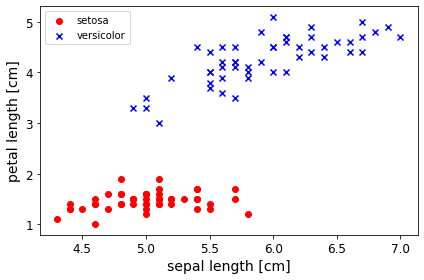

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# setosa와 versicolor를 선택
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# 꽃받침 길이와 꽃잎 길이를 추출
X = df.iloc[0:100, [0, 2]].values

# 산점도 시각화
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
           color='blue', marker='x', label='versicolor')
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
save_fig('Iris_scatter')
plt.show()

이 산점도는 붓꽃 데이터셋에 있는 샘플들이 꽃받침 길이와 꽃잎 길이 두 개의 특성 축을 따라 분포된 형태를 보여 준다. 이런 2차원 부분 공간에서는 선형 결정 경계로 Setosa와 Versicolor 꽃을 구분하기 충분할 것 같다. 퍼셉트론 같은 선형 분류기가 이 데이터셋의 꽃을 완벽하게 분류할 것이다.

이제 붓꽃 데이터셋에서 추출한 일부 데이터에서 퍼셉트론 알고리즘을 훈련해 보자. 에포크 대비 잘못 분류된 오차를 그래프로 그려서, 알고리즘이 수렴하여 두 붓꽃 클래스를 구분하는 결정 경계를 찾는지 확인하겠다.

그림 저장: ppn_epoch_error


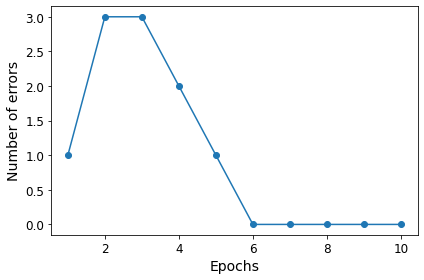

In [12]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)
plt.plot(range(1, len(ppn.errors_) + 1),
         ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of errors')
save_fig('ppn_epoch_error')
plt.show()

위 그림에서 볼 수 있듯이 퍼셉트론은 여섯 번째 에포크 이후에 수렴했고 훈련 샘플을 완벽하게 분류했다. 이제 간단한 함수를 만들어 2차원 데이터셋의 결정 경계를 시각화해 보자.

In [13]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 설정합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플의 산점도를 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

먼저 colors와 markers를 정의하고 ListedColormap을 사용하여 colors 리스트에서 컬러맵을 만든다. 두 특성의 최솟값과 최댓값을 찾고 이 벡터로 넘파이 <code>meshgrid()</code>함수로 그리드<sup>grid</sup> 배열 xx1과 xx2 쌍을 만든다. 두 특성의 차원에서 퍼셉트론 분류기를 훈련했기 때문에 그리드 배열을 펼치고 훈련 데이터와 같은 개수의 열이 되도록 만든다. <code>predict()</code>메서드로 그리드 각 포인트에 대응하는 클래스 레이블 Z를 예측한다.

클래스 레이블 Z를 xx1, xx2 같은 차원의 그리드로 크기를 변경한 후 맷플롯립의 <code>contourf()</code>함수로 등고선 그래프를 그린다. 그리드 배열에 대해 예측한 클래스를 각기 다른 색깔로 매핑하여 결정 영역을 나타낸다.

C:\Users\Sangjin\AppData\Local\Temp\ipykernel_143064\3284501193.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


그림 저장: ppn_decision_regions


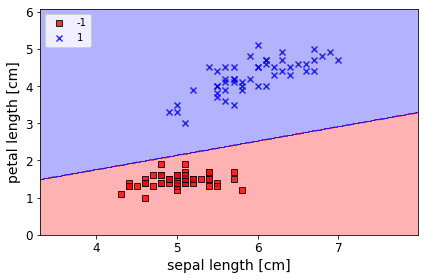

In [14]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
save_fig('ppn_decision_regions')
plt.show()

위 그림에서 볼 수 있듯이 퍼셉트론이 학습한 결정 경계는 두 개의 붓꽃으로 구성된 데이터셋의 모든 샘플을 완벽하게 분류한다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 퍼셉트론이 두 개의 붓꽃 클래스를 완벽하게 분류했지만 퍼셉트론의 가장 큰 문제점은 수렴에 있다. 프랑크 로젠블라트는 퍼셉트론 학습 규칙이 두 개의 클래스가 선형적인 초평면으로 구분될 수 있을 때 수렴한다는 것을 수학적으로 증명했다. 선형 결정 경계로 완벽하게 클래스가 구분되지 않는다면 최대 에포크를 지정하지 않는한 가중치 업데이트 과정이 멈추지 않는다.
</div>

# 사이킷런으로 퍼셉트론 훈련하기

역시 시각화를 위해 붓꽃 데이터셋에서 두 개의 특성만 사용한다. 

150개의 꽃 샘플에서 꽃잎 길이와 꽃잎 너비를 특성 행렬 X에 할당하고 이에 상응하는 꽃 품종에 해당하는 클래스 레이블을 벡터 y에 할당한다.<sup><a id="a09" href="#p09">9</a></sup>

In [15]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('클래스 레이블:', np.unique(y))

클래스 레이블: [0 1 2]


<code>np.unique(y)</code> 함수는 iris.target에 저장된 세 개의 고유한 클래스 레이블을 반환한다. 결과에서 보듯이 붓꽃의 클래스 이름인 Iris-setosa, Iris-versicolor, Iris-virginica는 이미 정수로 저장되어 었다(여기서는 0, 1, 2). 사이킷런의 많은 함수와 클래스 메서드는 문자열 형태의 클래스 레이블을 다룰 수 있다.<sup id="a10">[10](#p10)</sup> 정수 레이블이 권장되는 이유는 사소한 실수를 피할 수 있고 작은 메모리 영역을 차지하므로 계산 성능을 향상시키기 때문이다. 클래스 레이블을 정수로 인코딩하는 것은 대부분 머신 러닝 라이브러리들의 공통된 관례이기도 하다.

처음 본 데이터에서 훈련된 모델 성능을 평가하기 위해 데이터셋을 훈련 세트와 테스트 세트로 분할한다.

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

사이킷런 model_selection 모듈의 <code>train_test_split()</code> 함수를 사용해서 X와 y 배열을 랜덤하게 나눈다. 30%는 테스트 데이터(45개의 샘플), 70%는 훈련 데이터(105개의 샘플)가 된다.

<code>train_test_split()</code> 함수가 분할하기 전에 데이터를 미리 섞는다. 그렇지 않으면 클래스 0과 클래스 1이 훈련 세트에 들어가고 테스트 세트는 클래스 2의 샘플 45개만으로 구성된다. 데이터셋을 분할 전 무작위로 섞기 위해 사용되는 유사 난수 생성기에 random_state 매개변수로 고정된 랜덤 시드(random_state=1)를 전달한다. random_state를 고정하면 실행 결과를 재현할 수 있다.

마지막으로 startify=y를 통해 계층화<sup>stratification</sup> 기능을 사용한다. 여기서 계층화는 <code>train_test_split()</code> 함수가 훈련 세트와 테스트 세트의 클래스 레이블 비율을 입력 데이터셋과 동일하게 만든다는 의미다. 넘파이 <code>bincount()</code> 함수를 사용하여 배열에 있는 고유한 값의 등장 횟수를 헤아릴 수 있다. 계층화가 잘 되었는지 확인해 보자.

In [17]:
print('y의 레이블 카운트:', np.bincount(y))
print('y_train의 레이블 카운트:', np.bincount(y_train))
print('y_test의 레이블 카운트:', np.bincount(y_test))

y의 레이블 카운트: [50 50 50]
y_train의 레이블 카운트: [35 35 35]
y_test의 레이블 카운트: [15 15 15]


일부 머신 러닝 알고리즘들(트리 기반 알고리즘)을 제외한 대부분은 최적의 성능을 위해 어떤 식으로든지 특성 스케일을 조정하는 것이 필요하다.

경사 하강법은 특성 스케일을 조정하여 혜택을 볼 수 있는 많은 알고리즘 중 하나다. 이 절에서는 <b>표준화</b><sup>standardization</sup>라고 하는 특성 스케일 방법을 사용하겠다. 데이터에 표준 정규 분포의 성질을 부여하여 경사 하강법 학습이 좀 더 빠르게 수렴되도록 돕는다. 표준화는 각 특성의 평균을 0에 맞추고 특성의 표준 편차를 1로 만든다. 예를 들어 <i>j</i>번째 특성을 표준화하려면 모든 샘플에서 평균 <i>μ<sub>j</sub></i>를 빼고 표준 편차 <i>σ<sub>j</sub></i>로 나누면 된다.

<div style="text-align : center;">
     <img src="./images/formula/ml04/standardization.png">
</div>

여기서 <i><b>x</b><sub>j</sub></i>는 n개의 모든 훈련 샘플에서 j번째 특성 값을 포함한 벡터이다. 표준화 기법을 데이터셋의 각 특성 j에 적용한다. 표준화가 경사 하강법 학습에 도움이 되는 이유 중 하나는 다음 그림에 나온 것처럼 더 적은 단계를 거쳐 최적 혹은 좋은 솔루션을 찾기 때문이다. 다음 그림은 2차원 분류 문제에서 모델의 가중치에 따른 비용 함수의 등고선을 보여 준다.

<b>그림 18</b> 표준화 스케일링
<div style="text-align:center;">
    <img src="./images/Perceptron/표준화 스케일링.png">
</div>

여기서는 사이킷런의 preprocessing 모듈의 StandardSclaer 클래스를 사용하여 특성을 표준화하겠다.

In [18]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

앞 코드는 preprocessing 모듈에서 StandardScaler 클래스를 로드하고 새로운 StandardScaler 객체를 sc 변수에 할당한다. StandardScaler의 <code>fit()</code> 메서드는 훈련 세트의 각 특성 차원마다 <i>μ</i>(샘플 평균)과 <i>σ</i>(표준 편차)를 계산한다. <code>transform()</code> 메서드를 호출하면 계산된 <i>μ</i>와 <i>σ</i>를 사용하여 훈련 세트를 표준화한다. 훈련 세트와 테스트 세트의 샘플이 서로 같은 비율로 이동되도록 동일한 <i>μ</i>와 <i>σ</i>를 사용하여 테스트 세트를 표준화한다.

훈련 데이터를 표준화한 후 퍼셉트론 모델을 훈련한다. 사이킷런 알고리즘은 대부분 기본적으로 <b>OvR</b><sup>One-versus-Rest</sup> 방식을 사용하여 다중 분류<sup>multiclass classification</sup>를 지원한다. 세 개의 붓꽃 클래스를 퍼셉트론에 한 번에 주입하겠다. 코드는 다음과 같다.

In [19]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(max_iter=40, eta0=0.1, tol=1e-3, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, max_iter=40, random_state=1)

사이킷런의 인터페이스는 앞 절에서 직접 구현한 퍼셉트론과 비슷하다. linear_model 모듈에서 Perceptron 클래스를 로드하고 새로운 Perceptron 객체를 생성한 후 <code>fit()</code> 메서드를 사용하여 모델을 훈련한다. 모델 매개변수 eta0은 학습률이고 max_iter 매개변수는 (훈련 세트를 반복할) 에포크 횟수를 정의한다.

앞 절에서 했던 것처럼 적절한 학습률을 찾으려면 어느 정도 실험이 필요하다. 학습률이 너무 크면 알고리즘은 전역 최솟값을 지나친다. 학습률이 너무 작으면 학습 속도가 느리기 때문에 특히 대규모 데이터셋에서 수렴하기까지 많은 에포크가 필요하다. 에포크마다 훈련 세트를 섞은 결과가 나중에 그대로 재현되도록 random_state 매개변수를 사용한다.

사이킷런에서 모델을 훈련하고 앞 절 퍼셉트론 구현처럼 <code>predict()</code> 메서드로 예측을 만들 수 있다. 코드는 다음과 같다.

In [20]:
y_pred = ppn.predict(X_test_std)
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())

잘못 분류된 샘플 개수: 1


코드를 실행하면 이 퍼셉트론 모델이 45개의 샘플에서 1개를 잘못 분류한다. 테스트 세트에 대한 분류 오차는 약 0.022 또는 2.2%이다(1/45 ≒ 0.022).

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 분류 오차 대신 많은 머신 러닝 기술자는 모델의 분류 <b>정확도</b><sup>accuracy</sup>를 계산한다. 계산은 다음과 같다.<br>
    1 - 오차 = 0.98 또는 98%
</div>

사이킷런 라이브러리는 metrics 모듈 아래에 다양한 성능 지표를 구현해 놓았다. 예를 들어 테스트 세트에서 퍼셉트론의 분류 정확도는 다음과 같이 계산한다.

In [21]:
from sklearn.metrics import accuracy_score
print('정확도: %.2f' % accuracy_score(y_test, y_pred))

정확도: 0.98


y_test는 진짜 클래스 레이블이고 y_pred는 앞서 예측한 클래스 레이블이다. 사이킷런의 분류기<sup>classifier</sup>는 분류기의 예측 정확도를 계산하는 <code>score()</code> 메서드를 가지고 있다. 이 메서드는 <code>predict()</code> 메서드와 <code>accuracy_score()</code> 메서드를 연결하여 정확도를 계산한다.

In [22]:
print('정확도: %.2f' % ppn.score(X_test_std, y_test))

정확도: 0.98


마지막으로 앞절에서 만든 <code>plot_decision_regions()</code> 함수를 사용하여 새로운 퍼셉트론 모델의 결정 경계를 그려서 세 개의 붓꽃 샘플을 잘 구분하는지 시각화하겠다. 여기서는 조금 수정해서 테스트 세트의 샘플을 작은 원으로 다르게 표시하겠다.

In [23]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # 마커와 컬러맵을 설정합니다.
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # 테스트 샘플을 부각하여 그립니다.
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    facecolors='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

수정된 <code>plot_decision_regions()</code> 함수에 결과 그래프에 표시할 테스트 샘플 인덱스를 지정할 수 있다. 코드는 다음과 같다.

그림 저장: Perceptron_decision_regions


C:\Users\Sangjin\AppData\Local\Temp\ipykernel_143064\159487677.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


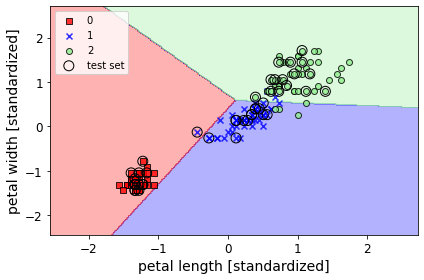

In [24]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
save_fig('Perceptron_decision_regions')
plt.show()

결과 그래프에서 볼 수 있듯이 세 개의 붓꽃 클래스는 선형 결정 경계로 완벽하게 분류되지 못한다.

앞 절에서 이야기했던 것을 떠올리면 퍼셉트론 알고리즘은 선형적으로 구분되지 않는 데이터셋에는 수렴하지 못한다. 에포크마다 적어도 하나의 샘플이 잘못 분류되기 때문에 가중치 업데이트가 끝도 없이 계속된다. 물론 학습률을 바꾸거나 에포크 횟수를 늘릴 수 있지만 퍼셉트론은 이 데이터셋에 절대 수렴하지 못한다. 실전에서 보통 퍼셉트론 알고리즘을 추천하지 않는 이유다. 

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> Perceptron은 물론 사이킷런의 함수나 클래스는 많은 매개변수를 가지고 있다. 여기서는 복잡하지 않도록 생략했다. 파이썬의 help 함수를 사용하여 매개변수에 대한 상세 내용을 볼 수 있다(예를 들어 help(Perceptron)). 또는 사이킷런의 훌륭한 온라인 문서를 참고하자(<a href='https://scikit-learn.org/stable/' target='blank'>https://scikit-learn.org/stable/</a>).
</div>

# 미주

<b id="p01">1</b> A Logical Calculus of the Ideas Immanent in Nervous Activity, W. S. McCulloch and W. Pitts, Bulletin of Mathematical Biophysics, 5(4): 115-113, 1943[↩](#a01)

<b id="p02">2</b> The Perceptron: A Perceiving and Recognizing Automaton, F.Rosenblatt, Cornell Aeronautical Laboratory, 1957[↩](#a02)

<b id="p03">3</b> 단위 계단 함수는 <i>z</i> ≥ 0일 때 1, 그렇지 않으면 0을 반환하는 함수이다.[↩](#a03)

<b id="p04">4</b> 입력과 가중치의 가중 합이 0인 식이 2차원이면 직선 방정식이 되지만, 3차원이면 평면 방정식이 되고 n차원이면 초평면<sup>hyperplane</sup> 방정식이된다. 이들은 모두 공간을 둘로 나눈다는 특징이 있다.[↩](#a04)

<b id="p05">5</b> 환원주의는 복잡하고 추상적인 개념을 더 단순한 요소로 명확하게 정의할 수 있다는 믿음이다. 예를 들어 생물의 어떤 현상을 물리적, 화학적으로 설명할 수 있다록 주장한다.[↩](#a05)

<b id="p06">6</b> iris.data 파일은 iris-setosa, iris-versicolor, iris-virginica가 순서대로 50개씩 들어 있는 CSV 파일이다.[↩](#a06)

<b id="p07">7</b> An Adpative "Adaline" Neuron Using Chemical "Memistors", Technical Report Number 1553-2, B. Widrow and others, Stanford Electron Labs, Standford, CA, October 1960[↩](#a07)

<b id="p08">8</b> <i>w<sub>0</sub></i>에 대한 그래디언트는 <i>x<sub>0</sub></i>가 1이므로 SSE 비용 함수의 편도 함수에서 오차의 합만 남는다.[↩](#a08)

<b id="p09">9</b> <code>load_iris()</code> 함수는 파이썬 딕셔너리와 유사한 사이킷런의 Bunch 클래스 객체를 반환한다. 이 객체에는 특성 행렬에 해당하는 data 속성, 타깃 벡터에 해당하는 target 속성, 특성 이름을 담은 feature_names, 타깃 이름을 담은 target_names 속성, 데이터셋에 대한 설명을 담은 DESCR 속성이 있다. 사이킷런은 붓꽃 데이터셋 외에도 여러 가지 간단한 데이터셋을 포함하고 있다. 전체 데이터셋 목록은 온라인 문서를 참고하자.[↩](#a09)

<b id="p10">10</b> LabelEncoder 클래스를 사용하여 레이블을 0~n_classes-1 사이의 정수로 바꾸거나 OvR 방식을 사용하는 경우 0, 1을 사용하는 이진 분류 문제로 만든다.[↩](#a10)